# Seagrass mapping in two mudflats in the Auray River

About a rapid evolution of seagrasses

Simon Oiry [](https://orcid.org/0000-0001-7161-5246) (Nantes Université, UR 2160, F-44000 Nantes, France)  
Bede Ffinian Rowe Davies [](https://orcid.org/0000-0001-6462-4347) (Nantes Université, UR 2160, F-44000 Nantes, France)  
July 22, 2024

Maps of seagrass in two sites in the Auray River. These two sites were studied by Maxime Daviray during his PhD. Seagrass appeared very quickly during his PhD. This work aims to describe this rapid evolution of seagrasses.

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'tidyterra'

The following object is masked from 'package:stats':

    filter

terra 1.7.71

Attaching package: 'terra'

The following object is masked from 'package:tidyr':

    extract


Attaching package: 'patchwork'

The following object is masked from 'package:terra':

    area


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

The data and scripts used for this work can be found [here](https://github.com/SigOiry/Seagrass_maps_Maxime).

# Materials & Methods

## Seagrass mapping using Sentinel-2

To map the seagrass extent over time, the Sentinel-2 constellation has been used. Level-2 images, which are already orthorectified and atmospherically corrected, have been downloaded using the Copernicus Platform \[@Copernicus_Sentinel\]. One low tide, cloud-free image per year, nearest to the period of the annual maximum seagrass biomass at this latitude has been used. A total of 8 images have been used (@tbl-tide-data).

| Acquisition Date (UTC) | Low Tide Time (UTC) | Time Difference with Low tide |
|:---------------------:|:------------------:|:---------------------------:|
|    2016-11-03 11:12    |       12 : 08       |          \+ 00 : 56           |
|    2017-10-04 11:08    |       09 : 09       |          \- 01 : 59           |
|    2018-09-29 11:08    |       12 : 43       |          \+ 01 : 35           |
|    2019-09-14 11:06    |       10 : 28       |          \+ 00 : 38           |
|    2020-08-04 11:06    |       10 : 45       |          \+ 00 : 21           |
|    2021-10-08 11:09    |       11 : 18       |          \- 00 : 09           |
|    2022-08-29 11:06    |       11 : 27       |          \- 00 : 21           |
|    2023-09-03 11:06    |       12 : 28       |          \- 01 : 22           |

The *Intertidal Classification of Europe: Categorising Reflectance of Emerged Areas of Marine vegetation with Sentinel-2* model has been applied to each Sentinel-2 image (ICE CREAMS, @Davies2024). It is a neural network classifier designed to identify and discriminate intertidal vegetation in Europe. Pixels of the Magnoliopsida class (seagrasses) have been isolated, and the Normalized Difference Vegetation Index (NDVI, @rouse1974monitoring), a commonly used remote sensing biomass proxy for vegetation, has been employed. The equation of @zoffoli2020sentinel have been used to transform NDVI values into Seagrass Percent Cover (\[@eq-std\]). Only pixels with SPC values above 20%, corresponding to high biomass pixel have been considered in order to avoid confusion with other class of vegetation.

$$
SPC = 172.06 \times NDVI - 22.18
$$ {#eq-std}

Maps and analysis have then been performed using the *Terra* package of R, in a *Tidyverse* workflow \[@hijmans2023terra ; @wickham2017easily\].

# Results

## Evolution of the spatial distribution of seagrasses over time

The time series of the seagrass percent cover between 2016 and 2023 shows an overall increase in meadow extent at both sites(@fig-Maps). From 2019 onwards, the meadows became denser at Fort Espagnol, particularly in the northern part of the mudflat. At Kerouarc’h, the meadow was limited to small, sparse patches between 2016 and 2019. However, from 2021 onward, the seagrass meadow experienced a rapid expansion, covering almost the entire mudflat.

In [ ]:
rgb_list <- list.files("Data/RGB/", pattern = ".tif", recursive = TRUE, full.names = TRUE) %>%
  as_tibble() %>% 
  rename(path_rgb = "value") %>%  
  mutate(name = gsub(".*/","",path_rgb),                 # Extract the filename
         year = substr(name,1,4)) %>% 
  dplyr::select(-name)

img_list <- list.files("Data/ICECREAMS/", pattern = ".tif", recursive = TRUE, full.names = TRUE) %>% 
  as_tibble() %>% 
  rename(path_pred = "value") %>% 
  mutate(name = gsub(".*/","",path_pred),                 # Extract the filename
         year = substr(name,12,15),                  # Extract the year from the filename
         date = as.POSIXct(substr(name,12,19), format = "%Y%m%d")) %>% 
  left_join(rgb_list, by = "year")



# Extract and format the date
mask <- "Data/mask/Intertidal_mask_Auray.shp" %>% 
  vect()

for (i in 1:nrow(img_list)) {
  
  pred <- img_list$path_pred[i] %>% 
    rast(lyrs = 5) %>% 
    mask(mask) %>% 
    as.data.frame(xy=T) %>% 
    mutate(SPC20Unknown = case_when(SPC20Unknown < 30 ~ NA,
                     T ~ SPC20Unknown))
    
  rgb <- img_list$path_rgb[i] %>% 
    rast()

    for(site_i in 1:length(unique(mask$Site_Name))){
      
      if(site_i == 1){
        pts <- data.frame(x = 503531.927,
                          y = 5273622.724) %>% 
          vect(geom=c("x", "y"), crs = crs(mask))
        
        SPC_site_1 <- img_list$path_pred[i] %>% 
          rast(lyrs = 5) %>% 
        terra::extract(pts) %>% 
        pull(SPC20Unknown) %>% 
        round()
      
      }else{
        pts <- data.frame(x = 503383.759,
                          y = 5269955.079) %>% 
          vect(geom=c("x", "y"), crs = crs(mask))
        
        SPC_site_2 <- img_list$path_pred[i] %>% 
          rast(lyrs = 5) %>% 
        terra::extract(pts) %>% 
        pull(SPC20Unknown) %>% 
        round()
      }
      
      
      
      site <- unique(mask$Site_Name)[site_i]
    
      # Extract the mask for the current site
      ext <- mask[which(mask$Site_Name == site)] %>% 
        ext()
      
      resize_x <- (as.numeric(ext[2])- as.numeric(ext[1]))*0.2
      resize_y <- (as.numeric(ext[4])- as.numeric(ext[3]))*0.15

      text_position_x <- as.numeric(ext[1] + ((as.numeric(ext[2])- as.numeric(ext[1]))*0.1))
      text_position_y <- as.numeric(ext[3] - ((as.numeric(ext[4])- as.numeric(ext[3]))*0.12))

      
      plot <- ggplot()+
        geom_spatraster_rgb(data = rgb,
                            max_col_value = 0.8)+
        coord_sf(xlim = c(ext[1]-resize_x, ext[2]+resize_x),
                ylim = c(ext[3]-resize_y, ext[4]+resize_y)) +
        # geom_text(aes(x = text_position_x, y = text_position_y, label = img_list$year[i]), color = "white" , size = 5)+
        scale_fill_viridis_c(na.value = "transparent")+
        theme(axis.text = element_blank(),
              axis.title = element_blank(),
              axis.ticks = element_blank(),
              plot.margin = margin(0, 0, 0, 0, "mm"))
    
      if(site_i == 1){
        a <- plot +
          geom_tile(data = pred, aes(x = x, y = y, fill = SPC20Unknown), show.legend = F) + 
          geom_point(aes(x=503531.927,
                         y=5273622.724), color = "darkred", size = 5)+# Use a continuous color scale and make NA values transparent

          geom_text(aes(x = 503360, y = 5274145, label = "Fort Espagnol" ), color = "white" , size = 7) +
          geom_text(aes(x = 503275.7, y = 5274073, label = img_list$year[i]), color = "white" , size = 7)
        
        if(img_list$year[i]=="2016"){
          a <- a +
            geom_rect(aes(xmin = 503436, xmax = 503738, ymin = 5273032, ymax = 5273120), fill = "white", alpha = 0.4)+
            ggspatial::annotation_scale(location = "br",
                                  text_cex=2,
                                  bar_cols = c("white", "black"))+
               ggforce::geom_mark_ellipse(aes(x=503531.927,
                         y=5273622.724,
                         label = "4B") ,
                         linewidth=0.3,
                         fill="darkred",
                         color = NA,
                         show.legend=F,
                         label.hjust = 0.5,
                         con.size = 2,
                         con.colour = "darkred",
                         label.fontsize = c(25,20),
                         alpha=0,
                         expand = unit(2, "mm") , 
                         radius = unit(2, "mm") , 
                         label.buffer = unit(10, "mm") ,
                         label.fill = rgb(1,1,1,0.4))
        }
        
        if(SPC_site_1 != 0){
          a = a + geom_text(aes(x = 503331.7, y = 5273103, label = paste0("SPC : ", SPC_site_1,"%")), color = "white" , size = 7)
        }
      }else{
        b = plot +
          geom_text(aes(x = 502650, y = 5271835, label = "Kerouarc'h" ), color = "white" , size = 7)
      
        if(img_list$year[i]=="2016"){
          
          b <- b + geom_tile(data = pred, aes(x = x, y = y, fill = SPC20Unknown))  +
                labs(fill = "SPC (%)")+
                geom_rect(aes(xmin = 503282, xmax = 504282, ymin = 5269000, ymax = 5269250), fill = "white", alpha = 0.4)+
                theme(legend.position = c(.9,.85),
                      legend.background = element_rect(fill=scales::alpha('white', 0.4)),
                      legend.text = element_text(size = 15),
                      legend.title = element_text(size = 18,margin = margin(b = 15)),
                      legend.key.size = unit(0.7,"cm")
                      )+
                ggspatial::annotation_scale(location = "br",
                                    text_cex=2,
                                    bar_cols = c("white", "black"))+
            geom_point(aes(x=503383.759,
                         y=5269955.079), color = "darkred", size = 5)+
            ggforce::geom_mark_ellipse(aes(x=503383.759,
                     y=5269955.079,
                     label = "2C") ,
                     linewidth=0.3,
                     fill="darkred",
                     color = NA,
                     show.legend=F,
                     label.hjust = 0.5,
                     con.size = 2,
                     con.colour = "darkred",
                     label.fontsize = c(25,20),
                     alpha=0,
                     expand = unit(2, "mm") , 
                     radius = unit(2, "mm") , 
                     label.buffer = unit(10, "mm") ,
                     label.fill = rgb(1,1,1,0.4))

        }else{
          b = b + geom_tile(data = pred, aes(x = x, y = y, fill = SPC20Unknown), show.legend = F)+
            geom_point(aes(x=503383.759,
                         y=5269955.079), color = "darkred", size = 5)
        }
        
        if(SPC_site_2 != 0){
            b = b +
                 geom_text(aes(x = 502670, y = 5269205, label =  paste0("SPC : ", SPC_site_2,"%")), color = "white" , size = 7)

        }
      }
      
      
    }
  
  patchwork <- a+b
  ggsave(paste0("Output/Figs/maps/",img_list$year[i],"_maps.png"),patchwork, width = 832*3, height = 759*3, units = "px" )
}


read_png_as_ggplot <- function(file_path) {
  img <- readPNG(file_path)
  img_grob <- grid::rasterGrob(img, interpolate = TRUE)
   return(ggplot() +
    annotation_custom(img_grob, xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf) +
    theme_void())
}

png_files <- list.files(path = "Output/Figs/maps", pattern = "*.png", full.names = TRUE)

# Create a list of ggplot objects
plot_list <- lapply(png_files, read_png_as_ggplot)

# Combine plots into one
combined_plot <- do.call(grid.arrange, c(plot_list, ncol = 4))  # Change ncol to adjust the number of columns

ggsave("Output/Figs/Figure1.png",combined_plot, width = 2620*2, height = (2620*2)/2.3, units = "px")
ggsave("Manuscript/Figs/Figure1.png", combined_plot, width = 1000 * 4, height = (500 * 4), units = "px")

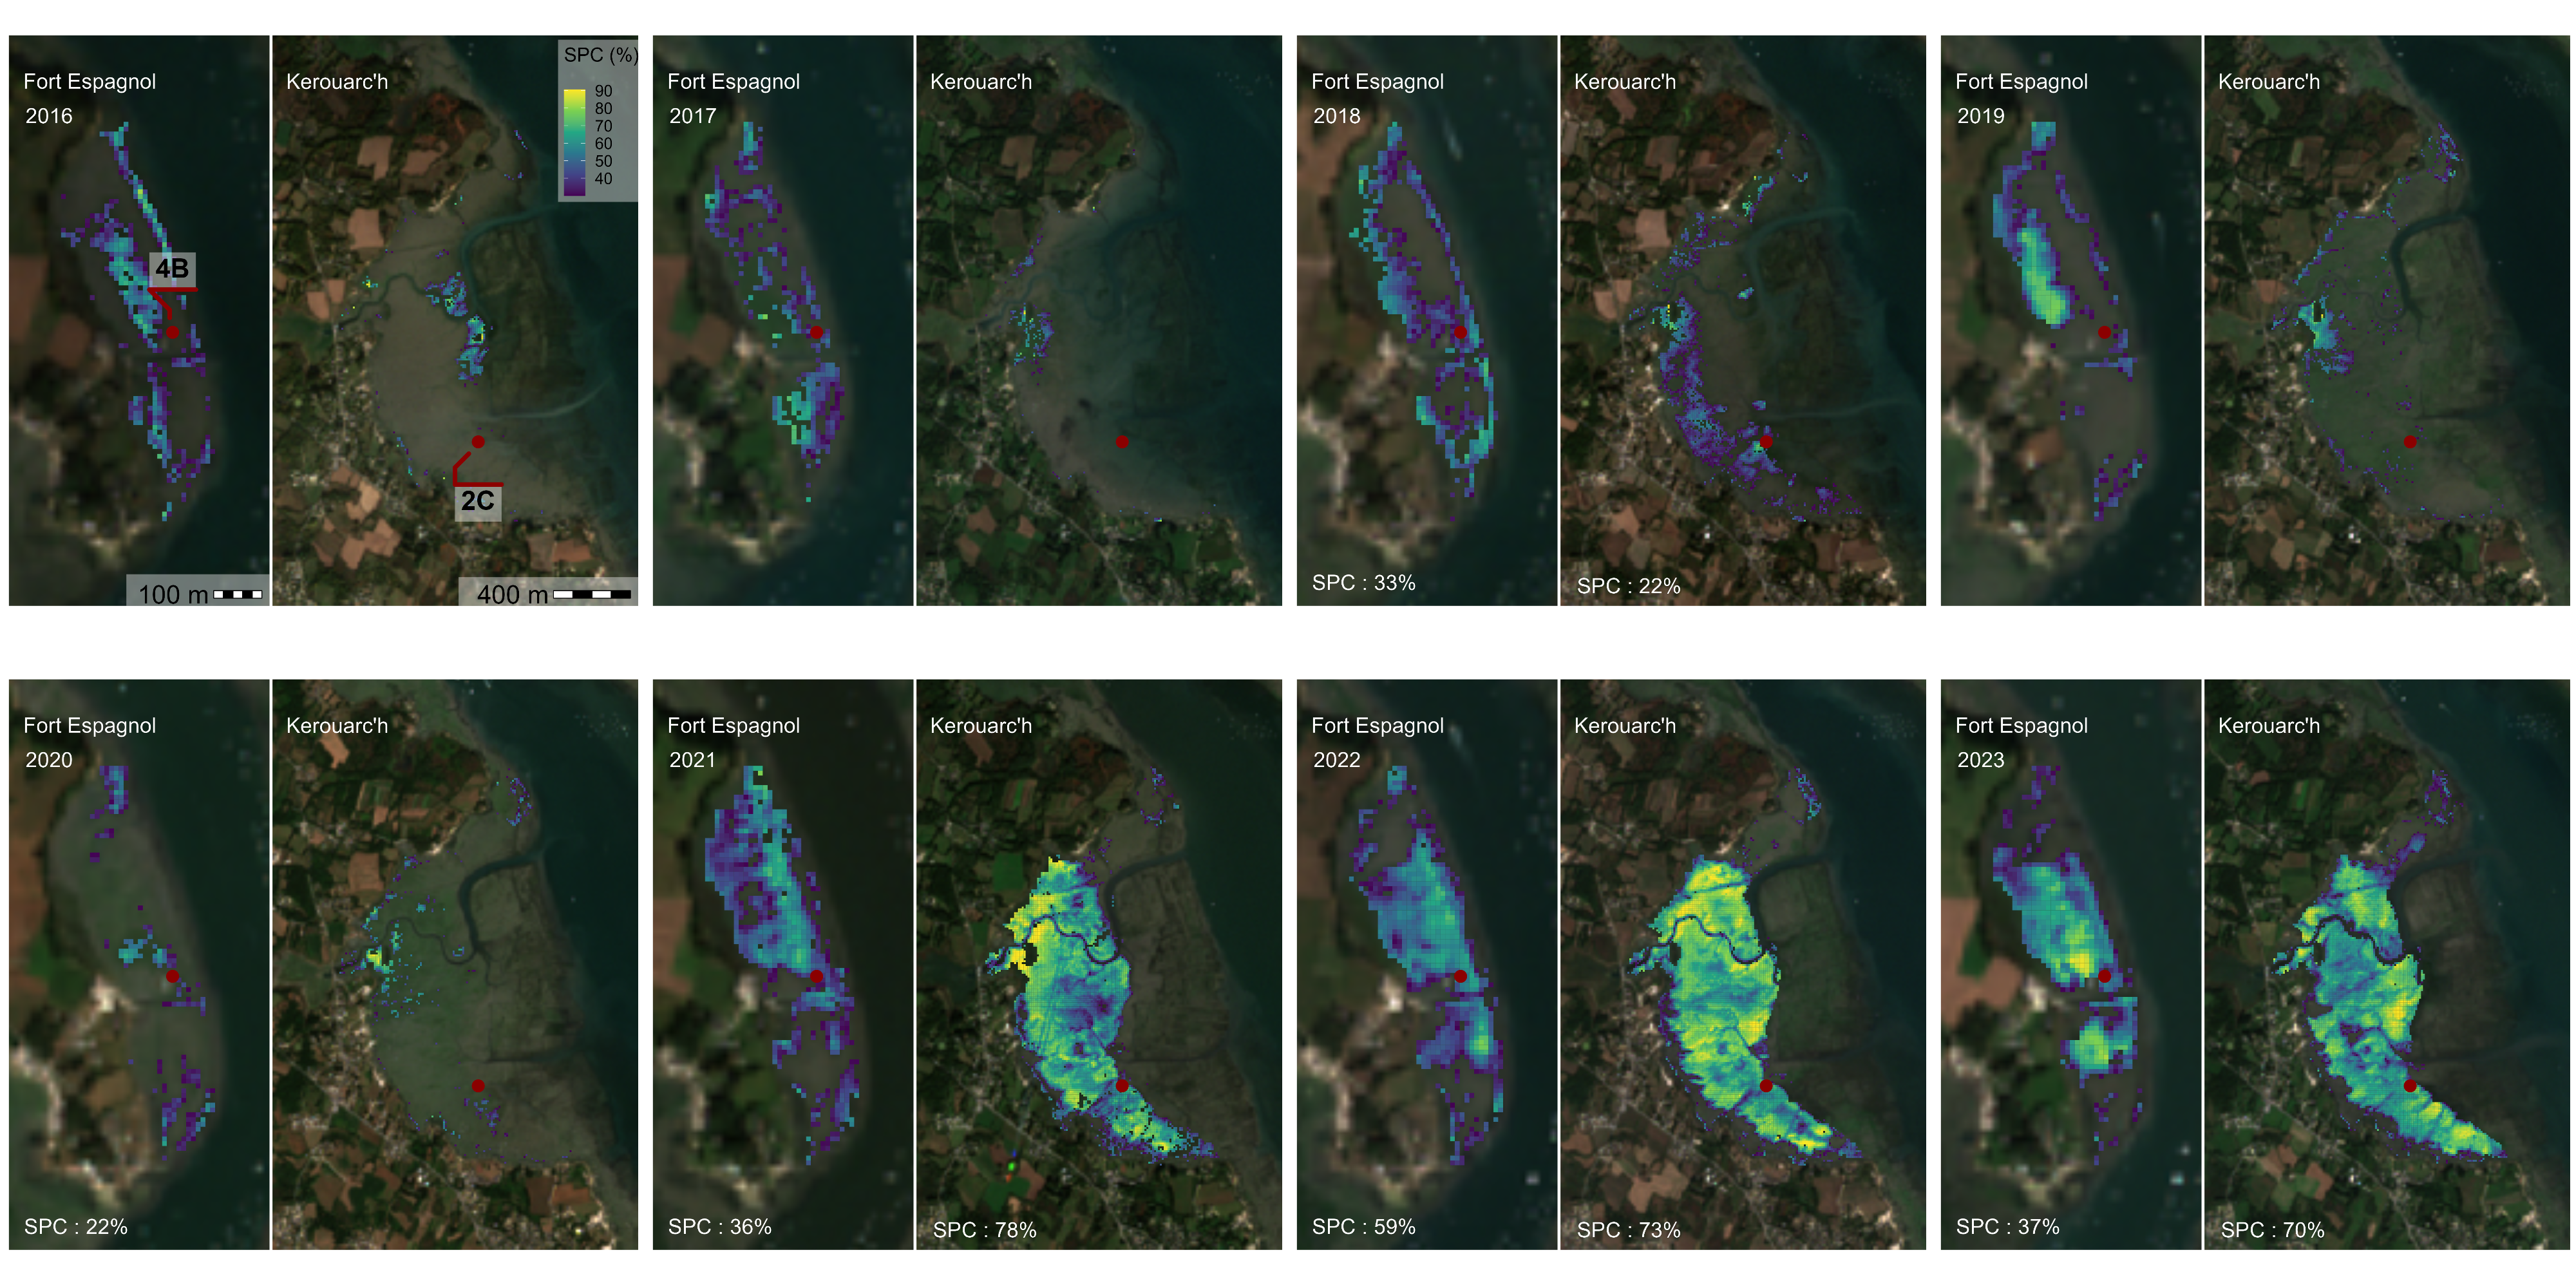

In [ ]:
knitr::include_graphics("Figs/Figure1.png")

## Evolution of the extent and density of the meadow over time

The maximum total extent of seagrass was reached in 2021 at Fort Espagnol and in 2022 at Kerouarc’h. Overall, during this period, the extent of the meadow at Fort Espagnol increased by approximately 50% and by about 90% at Kerouarc’h (@fig-Extent A). The density of the meadow remained relatively constant between 2016 and 2020 at both sites before increasing to 54% of the median SPC in 2023 at Fort Espagnol and 63% in 2022 at Kerouarc’h (@fig-Extent B). The year 2020 is an exception to these trends due to green algae covering the meadow in August, which impeded the detection of the underlying seagrass with remote sensing techniques.

In [ ]:
# List all .tif files in the "Data/ICECREAMS/" directory, including subdirectories, and convert to a tibble
img_list <- list.files("Data/ICECREAMS/", pattern = ".tif", recursive = TRUE, full.names = TRUE) %>% 
  as_tibble() %>% 
  rename(path = "value") %>% 
  mutate(
    name = gsub(".*/","", path),                 # Extract the filename
    year = substr(name, 12, 15),                 # Extract the year from the filename
    date = as.POSIXct(substr(name, 12, 19), format = "%Y%m%d")  # Extract and format the date
  )

# Load the intertidal mask shapefile
mask <- "Data/mask/Intertidal_mask_Auray.shp" %>% 
  vect()

# Select the mask for a specific site
mask_site <- mask[which(mask$Site_Name == unique(mask$Site_Name)[site_i])]

# Loop through each image and each site to process the data
for (img_i in 1:nrow(img_list)) {
  for (site_i in 1:length(unique(mask$Site_Name))) {
    
    # Extract the mask for the current site
    mask_site <- mask[which(mask$Site_Name == unique(mask$Site_Name)[site_i])]
    
    # Process the current image
    df <- img_list %>% 
      slice(img_i) %>% 
      pull(path) %>% 
      rast() %>% 
      crop(mask_site) %>%                    # Crop the image to the site mask
      as.data.frame(xy = TRUE) %>%           # Convert the raster to a data frame
      mutate(
        site = unique(mask$Site_Name)[site_i],  # Add site information
        date = img_list %>% 
          slice(img_i) %>% 
          pull(date),                   # Add date information
        year = img_list %>% 
          slice(img_i) %>% 
          pull(year) %>% 
          as.numeric()                 # Add year information
      ) %>%               
      dplyr::filter(
        out_class == 4 & SPC20Unknown > 20   # Filter the data for a specific class
      ) %>%        
      as_tibble()
    
    # Combine the data frames
    if (img_i == 1 & site_i == 1) {
      output <- df
    } else {
      output <- rbind(output, df)
    }
    
  }
  rm(df)
  rm(mask_site)
}

# Retrieve the area of each site
area <- mask %>% 
  sf::st_as_sf() %>% 
  sf::st_area() %>% 
  as.numeric() %>% 
  as.data.frame() %>% 
  rename(area = ".") %>% 
  mutate(site = unique(output$site))

# Define color scheme for sites
cols <- c("Kerouarc'h" = "#335145", "Fort Espagnol" = "#a9d8b8")

# Prepare area data again (seems redundant, might be a mistake)
area <- mask %>% 
  sf::st_as_sf() %>% 
  sf::st_area() %>% 
  as.numeric() %>% 
  as.data.frame() %>% 
  rename(area = ".") %>% 
  mutate(site = unique(output$site))

# Create the plot for relative seagrass extent
plot <- output %>% 
  group_by(year, site) %>% 
  reframe(seagrass_area = n() * 100 * (10^-6)) %>%
  ungroup() %>% 
  group_by(site) %>% 
  mutate(relative_surface = seagrass_area / max(seagrass_area)) %>% 
  left_join(area, by = "site") %>%
  ggplot() +
  geom_histogram(aes(x = year, y = relative_surface, fill = site), stat = "identity", position = position_dodge(), alpha = 0.8, color = "black", linewidth = 0.5) +
  annotate("text", x = 2015.5, y = 1, label = "A", size = 10) +
  ylab("Relative extent") +
  xlab("Year") +
  scale_fill_manual(values = cols) +
  labs(fill = "Sites:") + 
  theme_bw() +
  theme(
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 15),
    legend.text = element_text(size = 15),
    legend.title = element_text(size = 17),
    legend.position = "top"
  )

# Boxplot of SPC
plot_SPC <- output %>% 
  ggplot() + 
  geom_boxplot(aes(x = year, y = SPC20Unknown, fill = site, group = interaction(site, year)), outlier.alpha = 0.1, alpha = 0.8, color = "black", linewidth = 0.5, show.legend = FALSE) +
  annotate("text", x = 2015.5, y = 100, label = "B", size = 10) +
  ylab("Seagrass Cover (%)") +
  xlab("Year") +
  ylim(20, 100) +
  scale_fill_manual(values = cols) +
  labs(fill = "Sites:") + 
  theme_bw() +
  scale_y_continuous(position = "right") +
  theme(
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 15),
    legend.text = element_text(size = 15),
    legend.title = element_text(size = 17),
    legend.position = "top"
  )

stat_boxplot <- output %>% 
  group_by(site,year) %>% 
  reframe(med = median(SPC20Unknown))

# Combine the two plots and save the figure
a <- plot + plot_SPC
ggsave("Output/Figs/Figure2.png", a, width = 1000 * 4, height = (500 * 4), units = "px")
ggsave("Manuscript/Figs/Figure2.png", a, width = 1000 * 4, height = (500 * 4), units = "px")

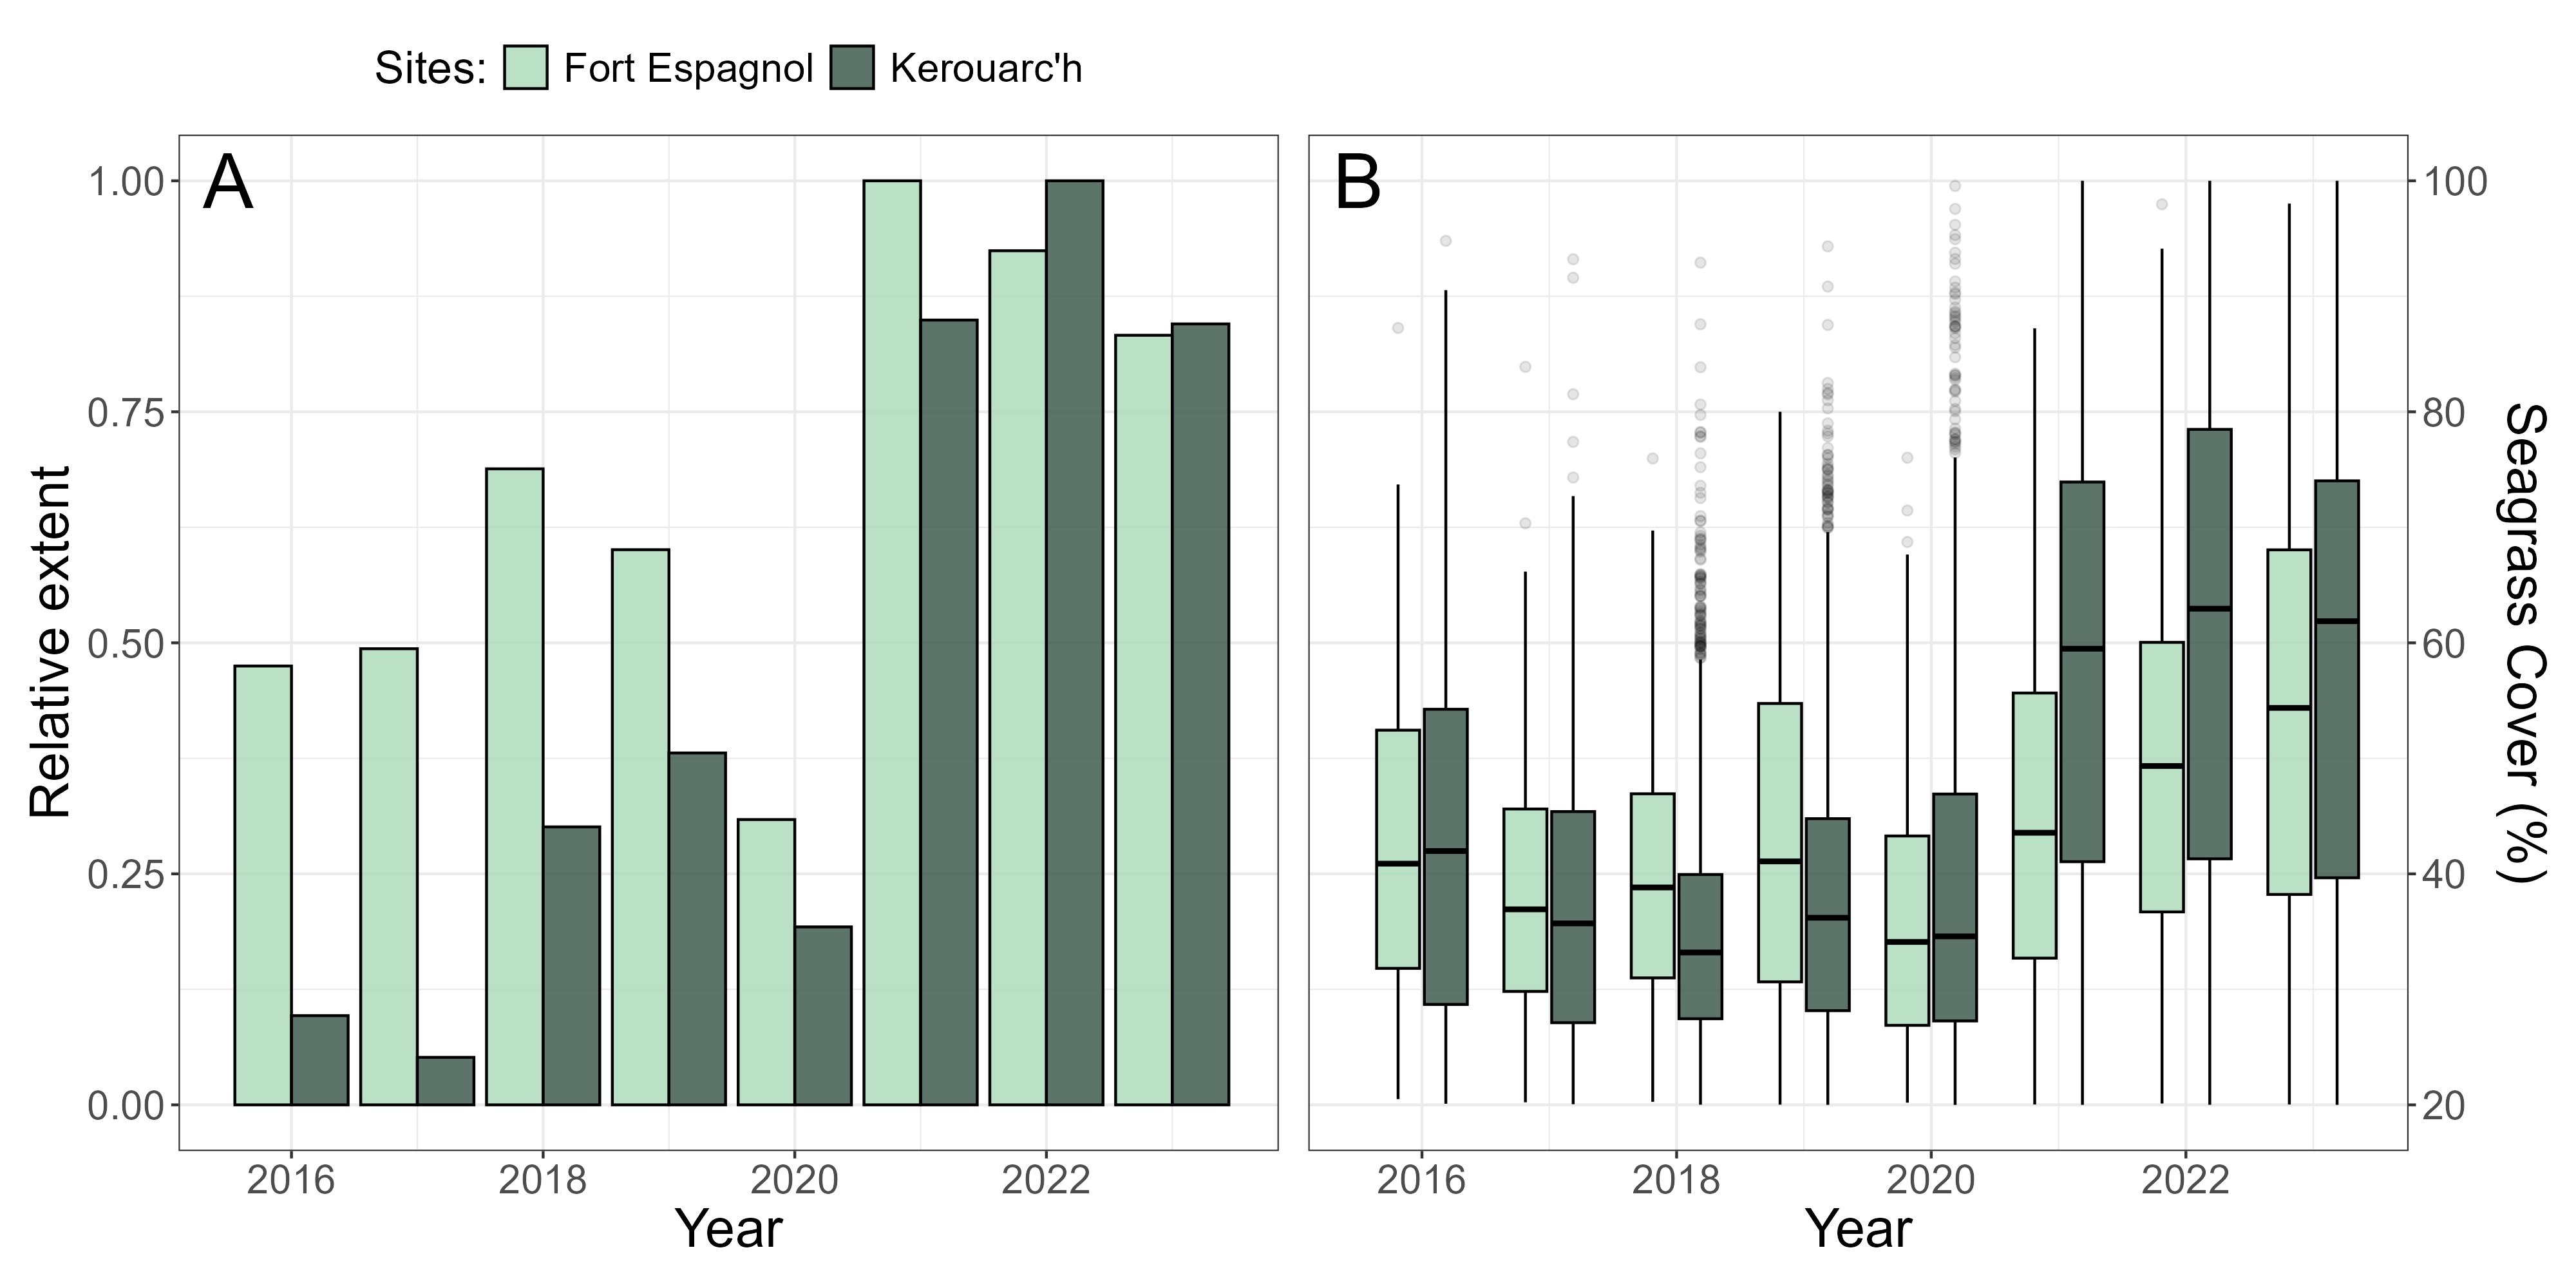

In [ ]:
knitr::include_graphics("Figs/Figure2.png")